# Minimization of non-smooth functions

## Subgradient method

- Analogue of the gradient descent for non-smooth convex function

$$
x_{k+1} = x_k - \alpha_k g_k,
$$

where $g_k$ is subgradient in $x_k$

- What is the difference between GD and subgradient method?

$$ f(x, y) = |x| + 2|y| $$ 

at point $(1, 0)$

### Step size selection

- Constant
- Decreasing sequence $\alpha_k \to 0$ and $\sum_{k=1}^{\infty} \alpha_k = \infty$

### Convergence analysis

- $\|x_{k+1} - x^*\|^2_2 = \|x_k - \alpha_k g_k - x^*\|_2^2 \leq \|x_k - x^*\|^2_2 - 2\alpha_k g^{\top}_k(x_k - x^*) + \alpha^2_k \|g_k\|_2^2 \leq \|x_k - x^*\|_2 - 2\alpha_k (f(x_k) - f^*) + \alpha^2_k \|g\|_2^2$
- Denote by $f_{best}^{(k)}$ the smallest value of after $k$ iterations 

$$
2 \left(\sum_{i=1}^k \alpha_i\right) (f^{(k)}_{best} - f^*) \leq \| x_0 - x^*\|_2^2 - \|x_k - x^* \|_2^2 + \sum_{i=1}^k \alpha^2_i \|g_i\|_2^2 \leq \| x_0 - x^*\|_2^2 + \sum_{i=1}^k \alpha^2_i \|g_i\|_2^2
$$


#### Constant step size

$$
f^{(k)}_{best} - f^* \leq \frac{\| x_0 - x^*\|_2^2}{2k\alpha} + \frac{G^2 \alpha}{2}
$$

- What is $G$?
- Dow we have convergence for $f$?

### Decreasing sequence

- $\alpha_i \to 0$ and $\sum_i^{\infty}\alpha_i = \infty$

$$
f^{(k)}_{best} - f^* \leq \frac{\| x_0 - x^*\|_2^2 + G^2 \sum_{i=1}^k \alpha_i^2}{2\sum_{i=1}^k \alpha_i}
$$

## Main rules for computing subgradients

- Definition: subgradient of $g$ at point $x$: $f(y) \geq f(x) + \langle g, y - x \rangle$ for all $y$

    - $f(x) = |x|$
    - $f(x) = \| x\|_2$
- Sum with non-negative weights: if $f(x) = \alpha_1 f_1(x) + \alpha_2 f_2(x), \alpha_1, \alpha_2 \geq 0$ and convex, then $\partial f(x) = \alpha_1 \partial f_1(x) + \alpha_2 f_2(x)$
    - $f(x) = \|x\|_1$
- Pointwise maximum
    - If $f(x) = \max_{k=1,\dots,m} \{ f_1(x),\dots,f_m(x) \}$ then 
    $$ \partial f (x) = conv\left(\bigcup\limits_{i \in I(x)} \partial f_i(x) \right),$$
    
    where $I(x) = \{ k \mid f_k(x) = f(x) \}$

### Experiments

$$
\|Ax - b\|_1 \to \min_x
$$

In [137]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss

m, n = 100, 500
A = np.random.randn(m, n)
x_true = np.random.randn(n)
b = A.dot(x_true)

In [138]:
import cvxpy as cvx
x = cvx.Variable(n)
problem = cvx.Problem(cvx.Minimize(cvx.norm1(A * x - b)))
problem.solve()

9.198086631982463e-16

In [139]:
problem.value

9.198086631982463e-16

In [140]:
f = lambda x: np.linalg.norm(A.dot(x) - b, 1)
subgrad = lambda x: A.T.dot(np.sign(A.dot(x) - b))

sg_methods = {
    "SM 1 / k": methods.fo.SubgradientMethod(f, subgrad, ss.InvIterStepSize()),
    "SM fixed": methods.fo.SubgradientMethod(f, subgrad, ss.ConstantStepSize(1e-3)),
    "SM scaled fix": methods.fo.SubgradientMethod(f, subgrad, 
                                                  ss.ScaledConstantStepSize(1.)),
}

In [144]:
x0 = np.random.randn(n)
max_iter = 5000

In [145]:
for m in sg_methods:
    _ = sg_methods[m].solve(x0=x0, max_iter=max_iter)

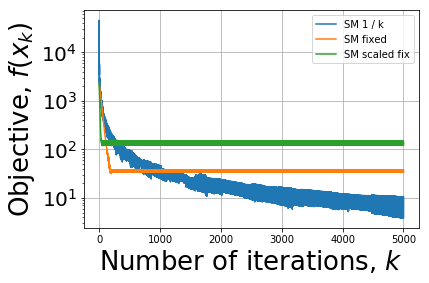

In [146]:
for m in sg_methods:
    plt.semilogy([f(x) for x in sg_methods[m].get_convergence()], label=m)
plt.legend()
plt.xlabel(r"Number of iterations, $k$", fontsize=26)
plt.ylabel(r"Objective, $f(x_k)$", fontsize=26)
plt.yticks(fontsize=20)
plt.grid(True)

## Proximal methods

- Look into black box
- Acceleration through model specification

### Reminder of ODE interpretation of gradient descent

Consider the following ODE

$$
\frac{dx}{dt} = -f'(x(t))
$$

and after discretization

$$
\frac{x_{k+1} - x_k}{\alpha} = -f'(x_k),
$$

where $\alpha = t_{k+1} - t_k$ is a grid step and $x_k \equiv x(t_k)$

From this follows 

$$
x_{k+1} = x_k - \alpha f'(x_k),
$$

which is equivalent to gradient descent method

### Proximal method as backward Euler scheme

$$
\frac{dx}{dt} = -f'(x(t))
$$

and after discretization in backward manner

$$
\frac{x_{k+1} - x_k}{\alpha} = -f'({\color{red}{x_{k+1}}}),
$$

After some re-arrangements

\begin{align*}
& \left(\frac{1}{2\alpha} \|u - x_k\|_2^2 + f(u) \right)'(x_{k+1}) = 0 \\
& x_{k+1} = \arg\min_u \left(f(u) + \frac{1}{2\alpha} \|u - x_k\|_2^2\right) = prox_{\alpha f}(x_k)
\end{align*}



### Example: iterative refinement

The method to solve positive semi-definite linear system given Cholesky factorization of $A + \epsilon I$ for some $\epsilon$

$$ f(x) = \frac{1}{2}x^{\top}Ax - b^{\top}x \to \min_x, $$

where $A \in \mathbb{S}^n_+$

\begin{align*}
prox_{\alpha f} (x_k) & = \arg\min_u \left(\frac{1}{2}u^{\top}Au - b^{\top}u + \frac{1}{2\alpha} \|u - x_k\|_2^2\right) \\
& = \left(A + (1/ \alpha) I\right)^{-1}\left(b + (1 / \alpha)x_k\right) \\
& = x_k + (A + \epsilon I)^{-1}(b - Ax_k)
\end{align*}

In [162]:
import scipy.linalg as splin
n = 500
k = 100
A = np.random.randn(k, n)
A = A.T @ A
spectrum = np.linalg.eigvalsh(A)
L, mu = max(spectrum), min(spectrum)
print(L, mu, L / mu)
x_true = np.random.randn(n)
b = A @ x_true
x0 = np.random.randn(n)
f = lambda x: 0.5 * x @ A @ x - b @ x
grad = lambda x: A @ x - b
print(f(x_true))
cho_factor = splin.cho_factor(A + 1 * np.eye(n))
prox_quad = lambda x: x + splin.cho_solve(cho_factor, b - A @ x)

1040.615098537212 -3.621346301923184e-13 -2873558648573801.5
-23329.33208953966


In [163]:
def prox(prox_func, x0, maxiter):
    conv = [x0.copy()]
    x = x0.copy()
    for i in range(maxiter):
        x = prox_func(x)
        conv.append(x.copy())
    return x, conv

In [164]:
import liboptpy.unconstr_solvers.fo as fo
methods = {
    "GD fixed": fo.GradientDescent(f, grad, ss.ExactLineSearch4Quad(A, b)),
    "Nesterov": fo.AcceleratedGD(f, grad, ss.ConstantStepSize(1e-3))
}
maxiter=15

In [165]:
for m in methods:
    methods[m].solve(max_iter=maxiter, x0=x0)
x_prox, conv_prox = prox(prox_quad, x0, maxiter)

(array([1.e-15, 1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01,
        1.e+01, 1.e+03, 1.e+05, 1.e+07]),
 <a list of 12 Text yticklabel objects>)

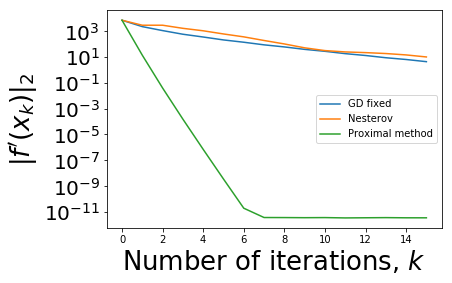

In [166]:
for m in methods:
    plt.plot([np.linalg.norm(grad(x)) for x in methods[m].get_convergence()], label=m)
plt.plot([np.linalg.norm(grad(x)) for x in conv_prox], label="Proximal method")
plt.yscale("log")
plt.legend()
plt.xlabel(r"Number of iterations, $k$", fontsize=26)
plt.ylabel(r"$\|f'(x_k)\|_2$", fontsize=26)
plt.yticks(fontsize=20)

### Properties of proximal map 

$$ x_{k+1} = prox_{f}(x_k) $$

a) Fixed point of proximal operator is equal to minimizer of $f$

$$ x^* = prox_f(x^*) $$ 

- Proximal map is not a contraction

- There exists theory on firm non-expansiveness of proximal operator

- Recent [paper](https://arxiv.org/pdf/1808.03971.pdf) proposes technique to deal with such kind of non-expansiveness

b) Resolvent of operator

$$ prox_{\alpha f}(x) = (I + \alpha f')^{-1}(x) $$

This property can be extended to subdifferential.

### Modified gradient step interpretation

Assume $f$ is twice differentiable and strong convex ($f''(x) \succ 0$).

1. Gradient method as approximation of proximal method

$$ x_{k+1} = prox_{\alpha f} (x_k) = (I + \alpha f')^{-1}(x_k) \approx x_k - \alpha f'(x_k) + o(\alpha), \; \alpha \to 0   $$

2. Proximal method for second-order approximation $\hat{f}(v) = f(x) + \langle f'(x), v - x \rangle + \frac{1}{2}\langle v - x, f''(x) (v - x) \rangle$

$$ prox_{\alpha \hat{f}}(x_k) = x_k - (f''(x_k) + (1 / \alpha)I)^{-1}f'(x_k)  $$

### Separable sum

If $f$ has the form

$$
f(x) = \sum_{i=1}^n f_i(x_i)
$$

then 

$$
prox_f(v)_i = prox_{f_i}(v_i)
$$

- High parallelization of the proximal operator computing 
- **Consensus form** of the problem

$$
\min \sum_{i=1}^n f_i(x) \to \min \sum_{i=1}^n f_i(x_i), \; \text{s.t. } x_1 = \ldots = x_n
$$

- Well-stated for distributed optimization

## Proximal gradient method (PGM)

Consider convex function $f$ such that

$$ f(x) = h(x) + g(x), $$

where $h(x)$ is convex differentiable, and $g(x)$ can be convex extended-value function, so $g: \mathbb{R}^n \to \mathbb{R} \cup \{+\infty\}$

Then the one step of the proximal gradient method is

$$ x_{k+1} = prox_{\alpha_k g} (x_k - \alpha_k h'(x_k)) $$

- Convergence rate $\mathcal{O}(1/k)$ for step size $\alpha_k \equiv \alpha \in (0, 1/L]$, where $L$ is Lipschitz constant of $f'$
- Backtracking procedure is available for adaptive search of $\alpha_k$

### Fixed point iteration interpretation

From the first-order optimality condition follows

\begin{align*}
& 0 \in \alpha h'(x^*) + \alpha\partial g(x^*)\\
& 0 \in \alpha h'(x^*) + x^* - x^* + \alpha\partial g(x^*)\\
& (I - \alpha h')(x^*) \in (I + \alpha \partial g)(x^*)\\
& x^* = (I + \alpha \partial g)^{-1}(I - \alpha h')(x^*)\\
& x^* = prox_{\alpha g}(x^* - \alpha h'(x^*))
\end{align*}

## Evaluation proximal operators

- General methods for smooth and non-smooth problems
- Separable sum property helps a lot!
- Solution via dual problem if constraints are simple

### Оrthogonal invariant functions

- **Definition.** If function $F$ such that $F(X) = F(UXV)$, where $U$ and $V$ are orthogonal matrices, then function $F$ is called **orthogonal invariant**
- Why such functions are important?

- $F(X) = F(diag(\sigma(X)))$
- **Claim.** Function $F$ is orthogonal invariant iff $F = f \circ \sigma$, where $f$ is absolutely symmetric, i.e. $f(Qx) = f(x)$ for any matrix $Q$ such that each column and each row have the single non-zero element from $\{ -1, +1 \}$
- **Claim.** $F$ is convex iff $f$ is convex
- Induce properties of $F$ from properties of $f$!

- Subdifferential

$$ \partial F(X) = \{ U \mathrm{diag}(\mu) V \mid \mu \in \partial f(\mathrm{diag}(\sigma(X))) \}, $$

where $U$ and $V$ are from SVD of $X$: $X = U \mathrm{diag}(\sigma) V$

- Proximal map

$$ prox_{\lambda F} (A) = U prox_{\lambda f} (\mathrm{diag}(\sigma(A)) V $$

-  Reduce computing proximal operator of $F$ to computing proximal operator of $f$ 

- Reduce extracting properties of $F$ and $X$ to extracting properties of $f$ and $\sigma(X)$

## Experiments

In [9]:
def prox_alg(f, f_grad, g_prox, x0, num_iter, beta=0.5, fix_lam=None, accel=False):
    conv = [x0]
    x = x0.copy()
    if accel:
        t_prev = 1
        t_next = (1 + np.sqrt(1 + 4 * t_prev**2)) / 2.
    if fix_lam is None:
        lam = 1.
    for i in range(num_iter):
        if accel and i > 0:
            x = x + (t_prev - 1) / t_next * (x - conv[-2])
            t_prev = t_next
            t_next = (1 + np.sqrt(1 + 4 * t_prev**2)) / 2.
        if fix_lam is None:
            while True:
                z = g_prox(x - lam * f_grad(x), lam)
                if f(z) <= f(x) + f_grad(x).dot(z - x) + \
                                np.linalg.norm(z - x)**2 / (2 * lam):
                    break
                else:
                    lam = lam * beta
        else:
            z = g_prox(x - fix_lam * f_grad(x), fix_lam)
        x = z.copy()
        conv.append(x)
    return x, conv

## Lasso problem

$$ \min \frac{1}{2}\|Ax - b\|_2^2 + \gamma \|x\|_1 $$

- $h(x) = \frac12 \|Ax - b\|_2^2$
- $g(x) = \gamma \|x\|_1$

In [167]:
f = lambda x: np.linalg.norm(A.dot(x) - y)**2 / 2
f_grad = lambda x: A.T.dot(A.dot(x) - y)
def g_prox(h, lam):
    return np.sign(h) * np.maximum(np.abs(h) - lam * gamma, 0) 

In [168]:
import sklearn.preprocessing as skprep
m = 500
n = 1000
A = np.random.rand(m, n)
A = skprep.normalize(A, norm="l2", axis=0)
L = np.linalg.eigvalsh(A.T.dot(A)).max()
x_true = np.random.randn(n)
x_true[np.random.rand(n) < 0.96] = 0
print("Number of nonzeros in x_true = {}".format(np.sum(x_true != 0)))
v = 9e-2 * np.random.randn(m)
y = A.dot(x_true) + v
gamma = 1

Number of nonzeros in x_true = 39


In [169]:
num_iter = 500
# x0 = np.zeros(n)
x0 = np.random.rand(n)

In [173]:
x, conv = prox_alg(f, f_grad, g_prox, x0, num_iter, fix_lam=1e-3)
print("Number nonzeros in x* = {}".format(np.sum(x != 0)))
print("f* = {}".format(f(x) + gamma * np.linalg.norm(x, 1)))
x_acc, conv_acc = prox_alg(f, f_grad, g_prox, x0, num_iter, 
                           fix_lam=1e-3, accel=True)
print("Number nonzeros in x* = {}".format(np.sum(x_acc != 0)))
print("f* = {}".format(f(x_acc) + gamma * np.linalg.norm(x_acc, 1)))
import liboptpy.unconstr_solvers.fo as fo
complete_f = lambda x: f(x) + gamma * np.linalg.norm(x, 1)
subgrad_f = lambda x: f_grad(x) + gamma * np.sign(x)
subgrad_method = fo.SubgradientMethod(complete_f, subgrad_f, ss.ConstantStepSize(1e-4))
x_subgrad = subgrad_method.solve(max_iter=max_iter, x0=x0)

print("Number nonzeros in x* = {}".format(np.sum(x_subgrad != 0)))
print("f* = {}".format(f(x_subgrad) + gamma * np.linalg.norm(x_subgrad, 1)))

Number nonzeros in x* = 11
f* = 6.323414467136995
Number nonzeros in x* = 0
f* = 6.053055221482773
Number nonzeros in x* = 1000
f* = 6.37415248533585


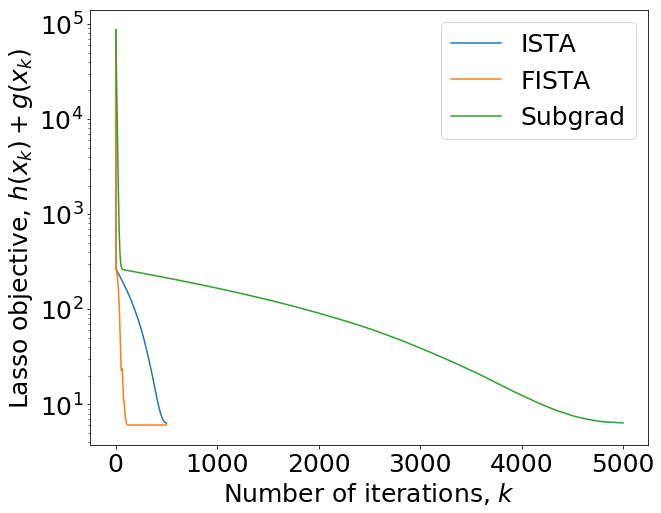

In [174]:
plt.figure(figsize=(10, 8))
fontsize=25
plt.plot([f(x) + gamma * np.linalg.norm(x, 1) for x in conv], label="ISTA")
plt.plot([f(x) + gamma * np.linalg.norm(x, 1) for x in conv_acc], label="FISTA")
plt.plot([f(x) + gamma * np.linalg.norm(x, 1) for x in subgrad_method.get_convergence()], label="Subgrad")
plt.legend(fontsize=fontsize)
plt.xlabel(r"Number of iterations, $k$", fontsize=fontsize)
plt.ylabel(r"Lasso objective, $h(x_k) + g(x_k)$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.yscale("log")

## Proximal algorithms highlights

- Very useful for composite objectives if one item is "simple"
- Many regularizers admit cheap prox evaluations
- Distributed optimization set up

## References

1. [Proximal algorithms](http://web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf) and related [sources](http://web.stanford.edu/~boyd/papers/prox_algs.html) by N. Parikh and S. Boyd 
2. [Gradient-based algorithms with applications to signal recovery problems](http://www.math.tau.ac.il/~teboulle/papers/gradient_chapter.pdf) by A. Beck and M. Teboulle
3. [Proximal Backpropagation](https://arxiv.org/abs/1706.04638) by T Frerix et al (ICLR 2018)
4. [Stochastic Proximal Gradient Descent with Acceleration Techniques](https://papers.nips.cc/paper/5610-stochastic-proximal-gradient-descent-with-acceleration-techniques.pdf) by A. Nitanda (NIPS 2014)